# 1. Importación de paquetes

In [1]:
# Para la lectura y transformación de datos
import pandas as pd

# Para realizar un train - test split
from sklearn.model_selection import train_test_split

# Para la visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Para la imputación de valores faltantes
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

# Para la transformación de variables
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

# 2. Lectura del dataset procedente del Notebook 1

In [2]:
df = pd.read_csv(r'../Dataset_con_transformaciones/df_after_notebook1.csv')
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233.0,1,0,150.0,0,2.3,0,0.0,1,1
1,37,1,2,130,250.0,0,1,187.0,0,3.5,0,0.0,2,1
2,41,0,1,130,204.0,0,0,172.0,0,1.4,2,0.0,2,1
3,56,1,1,120,236.0,0,1,178.0,0,0.8,2,0.0,2,1
4,57,0,0,120,354.0,0,1,163.0,1,0.6,2,0.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,0,140,241.0,0,1,123.0,1,0.2,1,0.0,3,0
298,45,1,3,110,264.0,0,1,132.0,0,1.2,1,0.0,3,0
299,68,1,0,144,193.0,1,1,141.0,0,3.4,1,2.0,3,0
300,57,1,0,130,131.0,0,1,115.0,1,1.2,1,1.0,3,0


In [3]:
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
num_cols = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
output_col = 'output'

In [4]:
# Corregimos los tipos de valores para las variables categóricas
for col in cat_cols:
    df[col] = df[col].astype('category')
    
# Corregimos el tipo de valor para la variable objetivo
df[output_col] = df[output_col].astype('category')

# 3. Train - Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df[cat_cols + num_cols], df[output_col], 
    test_size=0.2, 
    random_state=99, # Para controlar la reproducibilidad a la hora de mezclar los datos
    stratify=df[output_col] # Para controlar las proporciones de la variable objetivo
) 

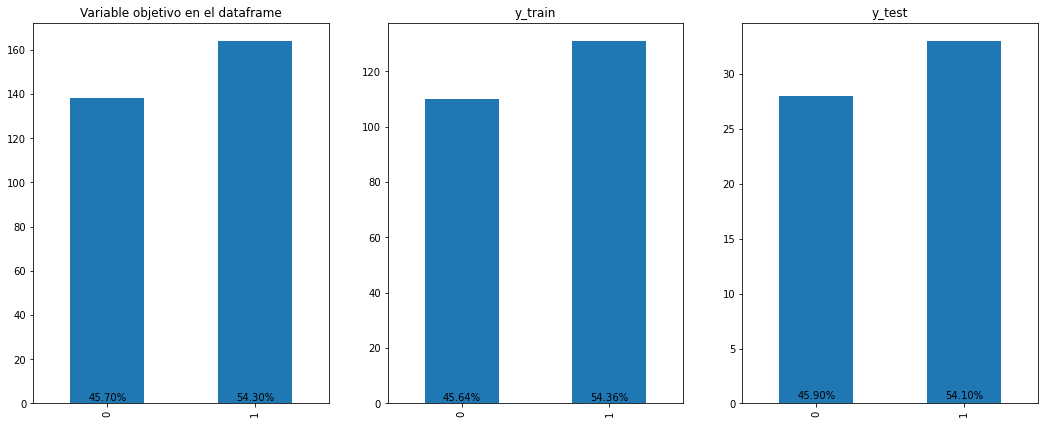

In [6]:
plt.figure(figsize=(18, 7))

# Histograma de la variable objetivo (df completo)
plt.subplot(1, 3, 1)
plt.title('Variable objetivo en el dataframe')
value_counts = df[output_col].value_counts().sort_index()
frecuencia_relativa = value_counts / len(df[output_col])
ax = value_counts.plot(kind='bar')
for i, v in enumerate(frecuencia_relativa):
    ax.text(i, v/2, f'{v:.2%}', ha='center', va='bottom', size='medium')

# Histograma de la variable objetivo (train)
plt.subplot(1, 3, 2)
plt.title('y_train')
value_counts = y_train.value_counts().sort_index()
frecuencia_relativa = value_counts / len(y_train)
ax = value_counts.plot(kind='bar')
for i, v in enumerate(frecuencia_relativa):
    ax.text(i, v/2, f'{v:.2%}', ha='center', va='bottom', size='medium')

# Histograma de la variable objetivo (test)
plt.subplot(1, 3, 3)
plt.title('y_test')
value_counts = y_test.value_counts().sort_index()
frecuencia_relativa = value_counts / len(y_test)
ax = value_counts.plot(kind='bar')
for i, v in enumerate(frecuencia_relativa):
    ax.text(i, v/2, f'{v:.2%}', ha='center', va='bottom', size='medium')

plt.show()

In [7]:
y_train.value_counts()

1    131
0    110
Name: output, dtype: int64

In [8]:
y_test.value_counts()

1    33
0    28
Name: output, dtype: int64

# 4. Transformación de variables

## 4.1. Imputación de valores faltantes

De acuerdo con lo expuesto en el Notebook 1, se va a realizar la imputación multivariante, lo cual implica reemplazar los valores faltantes en una variable utilizando información de múltiples variables relacionadas.

Para una imputación multivariante en variables numéricas, se puede utilizar la función IterativeImputer de scikit-learn.

In [9]:
def show_column_stats(df, var_name):
    '''
    Función que calcula la información de una columna numérica y el número de valores missings en la columna
    
    Input:
        df { DataFrame }: dataset a analizar
        var_name { str }: nombre de la columna a analizar
        
    Output: 
        df_var_describe { DataFrame }: dataset con los resultados de la información de la columna de df[var_name]
    '''
    stats = df[var_name].describe()
    missings_values_number = df[var_name].isnull().sum()
    df_var_describe = pd.DataFrame({
        'count': stats['count'],
        'mean': stats['mean'],
        'std': stats['std'],
        'min': stats['min'],
        '25%': stats['25%'],
        '50%': stats['50%'],
        '75%': stats['75%'],
        'max': stats['max'],
        'missings': missings_values_number
    }, index=[var_name])

    return df_var_describe

### 4.1.1. Variable chol

Según el Notebook 1, el grupo de variables con mayor correlación para imputar valores a chol es: "chol", "age"

In [10]:
# chol en X_train antes
show_column_stats(X_train, 'chol')

,count,mean,std,min,25%,50%,75%,max,missings
chol,238.0,244.983193,44.723715,126.0,211.25,243.0,275.0,354.0,3


In [11]:
# chol en X_test antes
show_column_stats(X_test, 'chol')

,count,mean,std,min,25%,50%,75%,max,missings
chol,59.0,236.372881,45.817817,131.0,201.0,234.0,256.0,360.0,2


In [12]:
# Imputación multivariante
imputer = IterativeImputer(random_state=99)
imputer.fit(X_train[["chol", "age"]])
X_train[["chol", "age"]] = imputer.transform(X_train[["chol", "age"]])
X_test[["chol", "age"]] = imputer.transform(X_test[["chol", "age"]])

In [13]:
# chol en X_train después
show_column_stats(X_train, 'chol')

,count,mean,std,min,25%,50%,75%,max,missings
chol,241.0,245.044582,44.447867,126.0,212.0,243.0,275.0,354.0,0


In [14]:
# chol en X_test después
show_column_stats(X_test, 'chol')

,count,mean,std,min,25%,50%,75%,max,missings
chol,61.0,236.91828,45.14751,131.0,203.0,234.0,254.553928,360.0,0


### 4.1.2. Variables thalachh y oldpeak

Según el Notebook 1, el grupo de variables con mayor correlación para imputar valores a thalachh y oldpeak es: "thalachh", "age", "oldpeak"

In [15]:
# thalachh en X_train antes
show_column_stats(X_train, 'thalachh')

,count,mean,std,min,25%,50%,75%,max,missings
thalachh,241.0,149.107884,22.62237,88.0,132.0,152.0,165.0,202.0,0


In [16]:
# thalachh en X_test antes
show_column_stats(X_test, 'thalachh')

,count,mean,std,min,25%,50%,75%,max,missings
thalachh,60.0,152.733333,21.880156,96.0,143.5,158.0,168.25,187.0,1


In [17]:
# oldpeak en X_train antes
show_column_stats(X_train, 'oldpeak')

,count,mean,std,min,25%,50%,75%,max,missings
oldpeak,237.0,1.016456,1.055345,0.0,0.0,0.8,1.6,4.0,4


In [18]:
# oldpeak en X_test antes
show_column_stats(X_test, 'oldpeak')

,count,mean,std,min,25%,50%,75%,max,missings
oldpeak,60.0,0.825,1.0219,0.0,0.0,0.4,1.4,4.0,1


In [19]:
# Imputación multivariante
imputer = IterativeImputer(random_state=99)
imputer.fit(X_train[["thalachh", "age", "oldpeak"]])
X_train[["thalachh", "age", "oldpeak"]] = imputer.transform(X_train[["thalachh", "age", "oldpeak"]])
X_test[["thalachh", "age", "oldpeak"]] = imputer.transform(X_test[["thalachh", "age", "oldpeak"]])

In [20]:
# thalachh en X_train después
show_column_stats(X_train, 'thalachh')

,count,mean,std,min,25%,50%,75%,max,missings
thalachh,241.0,149.107884,22.62237,88.0,132.0,152.0,165.0,202.0,0


In [21]:
# thalachh en X_test después
show_column_stats(X_test, 'thalachh')

,count,mean,std,min,25%,50%,75%,max,missings
thalachh,61.0,152.502065,21.772111,96.0,142.0,156.0,168.0,187.0,0


In [22]:
# oldpeak en X_train después
show_column_stats(X_train, 'oldpeak')

,count,mean,std,min,25%,50%,75%,max,missings
oldpeak,241.0,1.020985,1.047283,0.0,0.0,0.8,1.6,4.0,0


In [23]:
# oldpeak en X_test después
show_column_stats(X_test, 'oldpeak')

,count,mean,std,min,25%,50%,75%,max,missings
oldpeak,61.0,0.830559,1.014278,0.0,0.0,0.4,1.4,4.0,0


### 4.1.3. Variable caa

Según el Notebook 1, el grupo de variables con mayor correlación para imputar valores a thalachh y oldpeak es: "caa", "oldpeak".

En este caso, no se puede realizar una imputación multivariante ya que la función IterativeImputer de scikit-learn no permite imputar valores en registros missings de variables categóricas.

Por ello, se hará uso de la función SimpleImputer para reemplazar los registros missings por la moda de la serie de la variable "caa". Es decir, que no se tendrá en cuenta la correlación de esta variable con la variable "oldpeak" durante su imputación de valores.

In [24]:
# caa en X_train antes
X_train['caa'].isnull().sum()

3

In [25]:
# caa en X_test antes
X_test['caa'].isnull().sum()

1

In [26]:
imputer = SimpleImputer(strategy='most_frequent')
X_train[['caa']] = imputer.fit_transform(X_train[['caa']])
X_test[['caa']] = imputer.transform(X_test[['caa']])

In [27]:
# caa en X_train después
X_train['caa'].isnull().sum()

0

In [28]:
# caa en X_test después
X_test['caa'].isnull().sum()

0

Comprobación de que ya no existan missing values en el dataset:

In [29]:
X_train.isnull().any().any()

False

In [30]:
X_test.isnull().any().any()

False

## 4.2. Codificación de variables categóricas

Se convertirán en dummies las variables categóricas. Habrá una variable dummy por cada categoría en cada variable.

In [31]:
X_train = pd.get_dummies(X_train, columns=cat_cols)
X_test = pd.get_dummies(X_test, columns=cat_cols)

In [32]:
# Ejemplo de cómo se quedaría X_train después de convertir a dummies las variables categóricas
X_train

,age,trtbps,chol,thalachh,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slp_1,slp_2,caa_0.0,caa_1.0,caa_2.0,caa_3.0,thall_0,thall_1,thall_2,thall_3
164,67.0,160,286.000000,108.0,1.5,0,1,1,0,0,...,1,0,0,0,0,1,0,0,1,0
173,60.0,130,206.000000,132.0,2.4,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1
119,46.0,138,243.000000,152.0,0.0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
160,56.0,120,240.000000,169.0,0.0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0
78,52.0,128,205.000000,184.0,0.0,0,1,0,1,0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,54.0,108,309.000000,156.0,0.0,0,1,0,1,0,...,0,1,1,0,0,0,0,0,0,1
245,56.0,134,246.048774,150.0,1.9,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
105,68.0,120,211.000000,115.0,1.5,1,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0
193,60.0,140,185.000000,155.0,3.0,0,1,0,0,1,...,1,0,1,0,0,0,0,0,1,0


## 4.3. Transformación de variables continuas

En este caso, se hará uso de:
- Yeo-Johnson: puesto que todas las variables numéricas no siguen una distribución gaussiana, se hará uso de esta técnica para estabilizar la varianza y hacer que los datos se ajusten mejor a la distribución normal.
> Se utiliza la técnica Yeo-Johnson en vez de la Box-Cox porque esta última no es capaz de manejar valores iguales o inferiores a cero.
- Normalización (MinMax Scaling): Escala los valores de las variables al rango [0, 1].

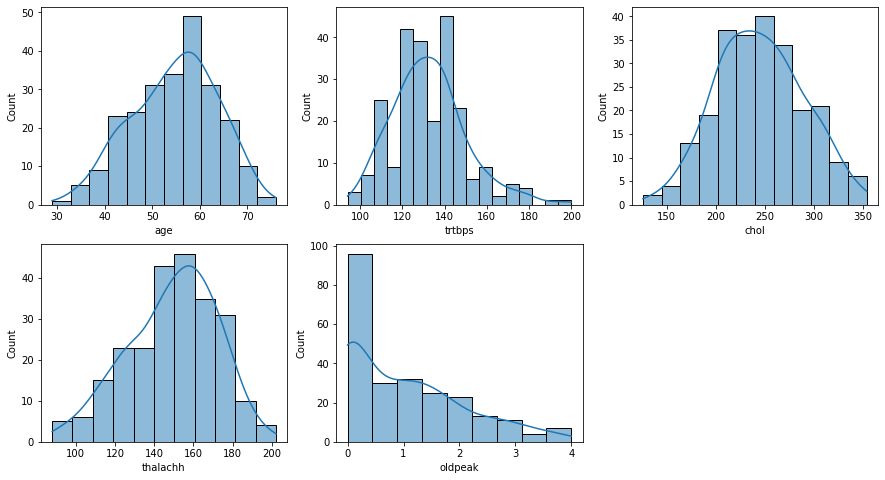

In [33]:
# Histograma de cada variable continua antes de las transformaciones en X_train

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
axes[5].axis('off') # Eliminar el sexto plot

for i, col in enumerate(num_cols):
    sns.histplot(X_train[col], ax=axes[i], kde=True)

plt.show()

In [34]:
for col in num_cols:
    # Yeo-Johnson
    power_transformer = PowerTransformer(method='yeo-johnson')
    X_train[col] = power_transformer.fit_transform(X_train[[col]]).flatten()
    X_test[col] = power_transformer.transform(X_test[[col]]).flatten()
    
    # MinMaxScaler
    min_max_scaler = MinMaxScaler()
    X_train[col] = min_max_scaler.fit_transform(X_train[[col]])
    X_test[col] = min_max_scaler.transform(X_test[[col]])   

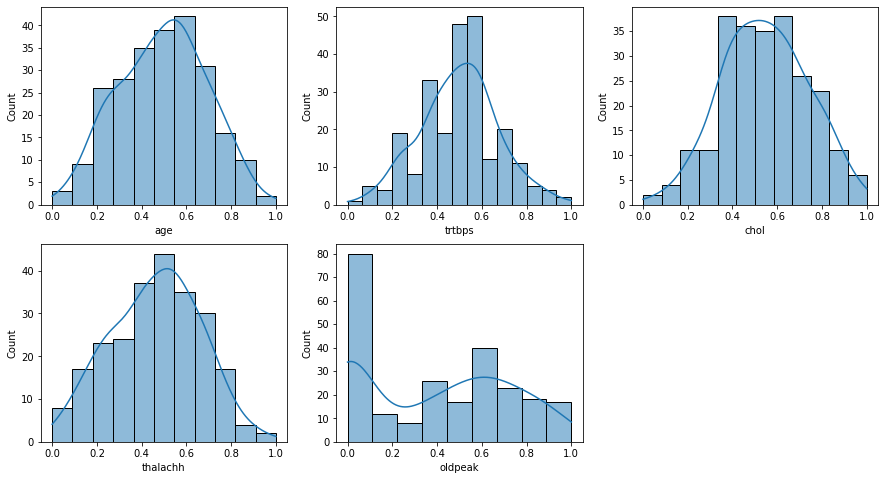

In [35]:
# Histograma de cada variable continua después de las transformaciones en X_train

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
axes[5].axis('off') # Eliminar el sexto plot

for i, col in enumerate(num_cols):
    sns.histplot(X_train[col], ax=axes[i], kde=True)

plt.show()

Con los gráficos superiores, podemos observar de manera visual el efecto de las dos transformaciones recién realizadas:
- Variables numéricas se ajustan mejor a una distribución normal 
- Variables numéricas escaladas entre 0 y 1

In [36]:
# Ejemplo de cómo se quedaría X_train después de la técnica Yeo-Johnson y la normalización
X_train

,age,trtbps,chol,thalachh,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slp_1,slp_2,caa_0.0,caa_1.0,caa_2.0,caa_3.0,thall_0,thall_1,thall_2,thall_3
164,0.770711,0.753184,0.723269,0.123573,0.633567,0,1,1,0,0,...,1,0,0,0,0,1,0,0,1,0
173,0.603793,0.489309,0.377758,0.301476,0.806545,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1
119,0.302085,0.568849,0.540707,0.474004,0.000000,1,0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
160,0.513100,0.377798,0.527712,0.637773,0.000000,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0
78,0.425942,0.468155,0.373268,0.795209,0.000000,0,1,0,1,0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.469072,0.222007,0.818364,0.511129,0.000000,0,1,0,1,0,...,0,1,1,0,0,0,0,0,0,1
245,0.513100,0.530055,0.553876,0.455768,0.719264,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
105,0.795385,0.377798,0.400138,0.172149,0.633567,1,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0
193,0.603793,0.587561,0.282392,0.501767,0.891092,0,1,0,0,1,...,1,0,1,0,0,0,0,0,1,0


# Guardar los datasets resultantes de este notebook

In [37]:
df_train = X_train.copy()
df_test = X_test.copy()


df_train['output'] = y_train
df_test['output'] = y_test

In [38]:
df_train.to_csv('../Dataset_con_transformaciones/df_train_after_notebook2.csv', index=False)
df_test.to_csv('../Dataset_con_transformaciones/df_test_after_notebook2.csv', index=False)